In [11]:
""" 
We aim to solve the simplest game (contract is 1000 fixed), 10 players using regret minimization
Goal: get cfr running on known solution game, before shifting to dif. contracts

Using regret minimization mentioned here:
    yt vid - https://www.youtube.com/watch?v=Wa-fRIBGZZI
    associated github - https://github.com/IanSullivan/PokerCFR/blob/main/RockPaperScissors.py
"""

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class RegretMinimization:
    def __init__(self):
        self.NUM_PLAYERS = 9
        self.NUM_ACTIONS = 30
        self.possible_actions = np.arange(self.NUM_ACTIONS) # 0 to 101
        
        self.regret_sums = np.zeros(shape=(self.NUM_PLAYERS, self.NUM_ACTIONS))
        self.strategy_sums = np.zeros(shape=(self.NUM_PLAYERS, self.NUM_ACTIONS))

    # Gets strategy from regret sum
    def get_strategy(self, regret_sum):
        new_sum = np.clip(regret_sum, a_min=0, a_max=None)
        normalizing_sum = np.sum(new_sum)
        if normalizing_sum > 0:
            new_sum /= normalizing_sum
        else:
            new_sum = np.repeat(1/self.NUM_ACTIONS, self.NUM_ACTIONS)
        return new_sum
    
    # Only used at very end; finds the average strategy used throughout
    def get_average_strategy(self, strategy_sum):
        average_strategy = np.zeros(self.NUM_ACTIONS)
        normalizing_sum = sum(strategy_sum)
        for a in range(self.NUM_ACTIONS):
            if normalizing_sum > 0:
                average_strategy[a] = strategy_sum[a] / normalizing_sum
            else:
                average_strategy[a] = 1.0 / self.NUM_ACTIONS
        return np.round(average_strategy, decimals=3)
    
    def graph_average_strategies(self):
        colors = plt.cm.tab10(np.linspace(0, 1, self.NUM_PLAYERS))
        for p in range(self.NUM_PLAYERS):
            strategy = self.get_average_strategy(self.strategy_sums[p])
            sns.lineplot(strategy, color=colors[p])
        plt.show()

    def get_action(self, strategy):
        return np.random.choice(self.possible_actions, p=strategy)

    # Based on others' actions array, find my utility
    def get_reward(self, my_action, opponent_action):

        # changing contract to be 15 or 45, instead of 50
        contractVals = [25,75]
        totalReward = 0

        for contract in contractVals:
            lessTotal = np.sum(np.where(opponent_action < my_action, opponent_action, 0))
            countSame = np.count_nonzero(np.array(opponent_action) == my_action)

            remainingCash = contract - lessTotal
            reward = 0
            if my_action <= remainingCash:
                available_fill = remainingCash//my_action if my_action > 0 else self.NUM_PLAYERS
                probChosen = min(1, 1/(1+countSame) * available_fill)
                reward = my_action * probChosen
            totalReward += reward
        return totalReward/len(contractVals)

    def train(self, iterations):

        for _ in range(iterations):
            # Get each players actions, update strategy sums
            actions = np.zeros(self.NUM_PLAYERS)
            for player in range(self.NUM_PLAYERS):
                strategy = self.get_strategy(self.regret_sums[player])
                self.strategy_sums[player] += strategy
                my_action = self.get_action(strategy)

                actions[player] = my_action

            # Get each players reward / regrets
            for player in range(self.NUM_PLAYERS):
                my_action = actions[player]
                others_actions = np.delete(actions, player)
                my_reward = self.get_reward(my_action, others_actions)

                for a in range(self.NUM_ACTIONS):
                    my_regret = self.get_reward(a, others_actions) - my_reward
                    self.regret_sums[player, a] += my_regret

player 0 policy: [0.    0.    0.    0.    0.    0.    0.997 0.    0.    0.    0.002 0.001
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 1 policy: [0.    0.    0.    0.    0.    0.    0.005 0.    0.    0.    0.012 0.276
 0.696 0.    0.    0.01  0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 2 policy: [0.    0.    0.    0.    0.    0.003 0.985 0.    0.    0.    0.01  0.001
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 3 policy: [0.    0.    0.    0.    0.    0.049 0.875 0.    0.    0.    0.071 0.005
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 4 policy: [0.    0.    0.    0.    0.    0.    0.999 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]
player 5 poli

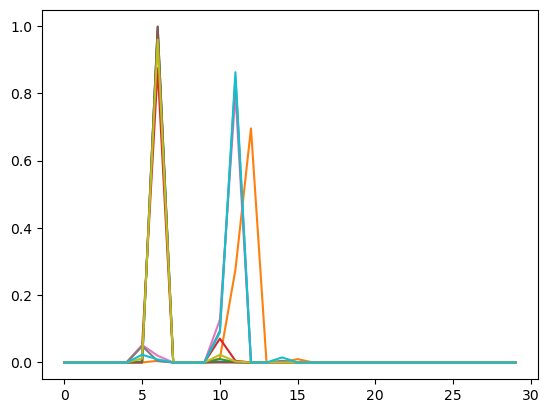

In [12]:
trainer = RegretMinimization()
trainer.train(10000)

for p in range(trainer.NUM_PLAYERS):
    policy = trainer.get_average_strategy(trainer.strategy_sums[p])
    print(f'player {p} policy:', policy)
trainer.graph_average_strategies()

In [4]:
for regret in trainer.regret_sums:
    strategy = trainer.get_strategy(regret)
    print(np.round(strategy, 3))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [10]:
trainer.get_reward(10, np.array([5,5,5,5,5,10,10,10,10]))

5.0